In [1]:
import numpy as np
import wavesim_functions as wave
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema
import cProfile
import pstats
import time
import io
import snakeviz

In [2]:
def main():
    np.random.seed(12345)
    write = False
    write_con = False

    # set up wave conditions
    hs = 25
    tp = 12
    depth = 100
    cond = False
    a = 0

    # set up arrays
    z_num = 150
    z_range = np.linspace(-depth, 50, z_num)
    dz = z_range[1] - z_range[0]

    num_sea_states = 2000
    sea_state_hours = 1
    full_period = 60**2 * sea_state_hours  # total time range in seconds
    waves_per_sea_state = full_period/tp

    freq = 1.00  # number of sample points per second
    nT = np.floor(full_period*freq)  # number of time points to evaluate
    t_num = int(nT)  # to work with rest of the code

    dt = 1/freq  # time step is determined by frequency
    t_range = np.linspace(-nT/2, nT/2 - 1, int(nT)) * dt  # centering time around 0

    f_range = np.linspace(1e-3, nT - 1, int(nT)) / (nT / freq)  # selecting frequency range from 0 to freq
    om_range = f_range * (2*np.pi)

    # get jonswap density
    jnswp_dens = wave.djonswap(f_range, hs, tp)

    # if we want new wave data
    if write:
        # set up arrays (don't actually need to do this for all)
        eta = np.empty([num_sea_states, t_num])
        base_shear = np.empty([num_sea_states, t_num])
        # populate arrays
        for i in range(num_sea_states):
            print(i)
            eta[i, :], u_x, _, du_x, _ = wave.fft_random_wave_sim(z_range, depth, a, om_range, jnswp_dens, cond)
            F = np.empty((t_num, z_num))
            for i_t, t in enumerate(t_range):
                for i_z, z in enumerate(z_range):
                    F[i_t, i_z] = wave.morison_load(u_x[i_t, i_z], du_x[i_t, i_z])
            base_shear[i, :] = np.sum(F, axis=1) * dz / 1e6

        np.savetxt('eta.txt', eta, delimiter=' ')
        np.savetxt('base_shear.txt', base_shear, delimiter=' ')

    # if we want to use the old wave data
    else:
        # read data from the text files
        eta = np.loadtxt('eta.txt')
        base_shear = np.loadtxt('base_shear.txt')

    # get max crest from each sea state
    two_hour_max_crests = np.empty(num_sea_states)
    for i_s in range(num_sea_states):
        slice = eta[i_s, :]
        two_hour_max_crests[i_s] = max(slice)

    # get max forces from each sea state
    two_hour_max_forces = np.empty(num_sea_states)
    for i_s in range(num_sea_states):
        slice = base_shear[i_s, :]
        two_hour_max_forces[i_s] = max(slice)

    # now do for conditional sim
    cond = True

    # get proposal sample and density of crest
    CoHmin = 0
    CoHmax = 2
    CoHnum = num_sea_states
    CoH = np.random.uniform(low=CoHmin, high=CoHmax, size=CoHnum)
    g = 1/((CoHmax-CoHmin)*hs)  # density for crest heights not CoH
    r_crests = np.sort(CoH * hs)

    # will simulate sea states of 2 minutes
    cond_state_min = 2
    cond_period = 60*cond_state_min
    waves_per_cond_state = cond_period/tp
    cond_per_full_state = sea_state_hours * 60 / cond_state_min

    # redo arrays
    freq = 1.00  # number of sample points per second
    nT = np.floor(cond_period*freq)  # number of time points to evaluate
    t_num = int(nT)  # to work with rest of the code

    dt = 1/freq  # time step is determined by frequency
    t_range = np.linspace(-nT/2, nT/2 - 1, int(nT)) * dt  # centering time around 0

    f_range = np.linspace(1e-3, nT - 1, int(nT)) / (nT / freq)  # selecting frequency range from 0 to freq
    om_range = f_range * (2*np.pi)

    # redo jonswap density
    jnswp_dens = wave.djonswap(f_range, hs, tp)

    if write_con:
        # generate wave data and write to text files
        eta = np.empty([num_sea_states, t_num])
        base_shear_con = np.empty([num_sea_states, t_num])
        for i in range(num_sea_states):
            print(i)
            a = r_crests[i]
            eta[i, :], u_x, _, du_x, _ = wave.fft_random_wave_sim(z_range, depth, a, om_range, jnswp_dens, cond)

            F = np.empty((t_num, z_num))
            for i_t, t in enumerate(t_range):
                for i_z, z in enumerate(z_range):
                    F[i_t, i_z] = wave.morison_load(u_x[i_t, i_z], du_x[i_t, i_z])
            base_shear_con[i, :] = np.sum(F, axis=1) * dz / 1e6

        np.savetxt('eta_con.txt', eta, delimiter=' ')
        np.savetxt('base_shear_con.txt', base_shear_con, delimiter=' ')

    else:
        # read wave date from txt files
        eta = np.loadtxt('eta_con.txt')
        base_shear_con = np.loadtxt('base_shear_con.txt')

    # get cond max crests and max forces
    cond_max_crests = np.empty(num_sea_states)
    cond_max_forces = np.empty(num_sea_states)
    for i_s in range(num_sea_states):
        mins = argrelextrema(eta[i_s, :], np.less)[0]
        lower_min = np.max(mins[mins < t_num/2])
        upper_min = np.min(mins[mins > t_num/2])
        slice = eta[i_s, lower_min:upper_min]
        cond_max_crests[i_s] = max(slice)
        # do forces here for a single wave
        slice = base_shear_con[i_s, lower_min:upper_min]
        cond_max_forces[i_s] = max(slice)

    # evaluated the 3 distributions at these points
    x = np.linspace(0, 2*hs, num=100)

    # get weights
    f = wave.rayleigh_pdf(r_crests, hs)
    fog = f/g

    # get simple IS dist
    sim_is_crest_cdf = np.empty(x.shape)
    for i_x, c in enumerate(x):
        sim_is_crest_cdf[i_x] = np.sum((r_crests < c) * fog)/np.sum(fog)

    # get true dist
    rayleigh_cdf = wave.rayleigh_cdf(x, hs)

    # get IS crest distribution
    crest_cdf_is_two_min_max = np.empty(x.shape)
    for i_c, c in enumerate(x):
        crest_cdf_is_two_min_max[i_c] = np.sum((cond_max_crests < c) * fog)/np.sum(fog)

    crest_cdf_is_sea_st_max = crest_cdf_is_two_min_max**(cond_per_full_state*waves_per_cond_state)

    crest_cdf_two_min_max = sim_is_crest_cdf**waves_per_cond_state
    rayleigh_cdf_two_min_max = rayleigh_cdf**waves_per_cond_state

    crest_cdf_sea_st_max = sim_is_crest_cdf**waves_per_sea_state
    rayleigh_cdf_sea_st_max = rayleigh_cdf**waves_per_sea_state

    plt.figure()
    plt.plot(r_crests, cond_max_crests, '.')
    plt.plot([0, 50], [0, 50], 'k')
    plt.show()

    mins = argrelextrema(eta[np.argmin(cond_max_crests), :], np.less)[0]
    lower_min = np.max(mins[mins < t_num/2])
    upper_min = np.min(mins[mins > t_num/2])

    plt.figure()
    plt.plot(t_range[lower_min:upper_min], eta[np.argmin(cond_max_crests), lower_min:upper_min])
    plt.show()

    print(CoH[np.argmax(cond_max_crests)] * hs)

    plt.figure()
    plt.subplot(1, 3, 1)
    plt.plot(x/hs, np.log10(1-sim_is_crest_cdf), '-k')
    plt.plot(x/hs, np.log10(1-rayleigh_cdf), '-r')

    plt.subplot(1, 3, 2)
    plt.plot(x/hs, np.log10(1-crest_cdf_two_min_max), '-k')
    plt.plot(x/hs, np.log10(1-rayleigh_cdf_two_min_max), '-r')
    plt.plot(x/hs, np.log10(1-crest_cdf_is_two_min_max), '--g')

    plt.subplot(1, 3, 3)
    plt.plot(x/hs, np.log10(1-crest_cdf_sea_st_max), '-k')
    plt.plot(x/hs, np.log10(1-rayleigh_cdf_sea_st_max), '-r')
    plt.plot(x/hs, np.log10(1-crest_cdf_is_sea_st_max), '--g')

    # evaluate the force distributions at these points
    x_f = np.linspace(min(cond_max_forces), max(cond_max_forces), num=100)

    # get emp force distribution 
    force_cdf_emp = np.empty(x.shape)
    for i_f, f in enumerate(x_f):
        force_cdf_emp[i_f] = np.sum(two_hour_max_forces < f)/num_sea_states

    # get IS force distribution
    force_cdf_IS = np.empty(x.shape)
    for i_f, f in enumerate(x_f):
        force_cdf_IS[i_f] = np.sum((cond_max_forces < f) * fog)/np.sum(fog)
    force_cdf_IS = force_cdf_IS**(cond_per_full_state*waves_per_cond_state)

    plt.figure()
    plt.plot(x_f, np.log10(1-force_cdf_emp), '-r')
    plt.plot(x_f, np.log10(1-force_cdf_IS), '-b')
    plt.show()

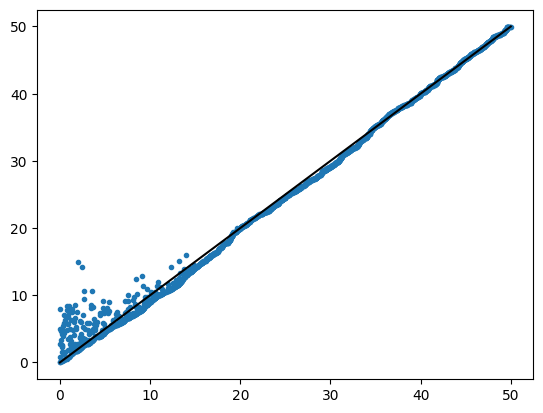

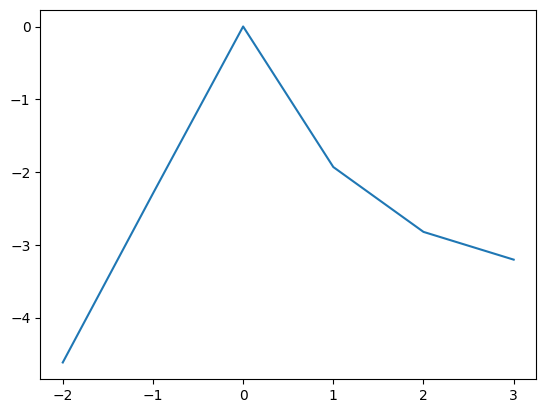

31.447540314481326


/tmp/ipykernel_137567/2400321988.py:184: RuntimeWarning: divide by zero encountered in log10
  plt.plot(x/hs, np.log10(1-sim_is_crest_cdf), '-k')
/tmp/ipykernel_137567/2400321988.py:188: RuntimeWarning: divide by zero encountered in log10
  plt.plot(x/hs, np.log10(1-crest_cdf_two_min_max), '-k')
/tmp/ipykernel_137567/2400321988.py:190: RuntimeWarning: divide by zero encountered in log10
  plt.plot(x/hs, np.log10(1-crest_cdf_is_two_min_max), '--g')
/tmp/ipykernel_137567/2400321988.py:193: RuntimeWarning: divide by zero encountered in log10
  plt.plot(x/hs, np.log10(1-crest_cdf_sea_st_max), '-k')
/tmp/ipykernel_137567/2400321988.py:195: RuntimeWarning: divide by zero encountered in log10
  plt.plot(x/hs, np.log10(1-crest_cdf_is_sea_st_max), '--g')
/tmp/ipykernel_137567/2400321988.py:212: RuntimeWarning: divide by zero encountered in log10
  plt.plot(x_f, np.log10(1-force_cdf_emp), '-r')


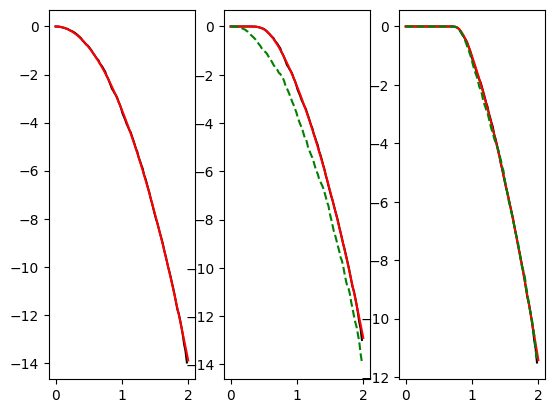

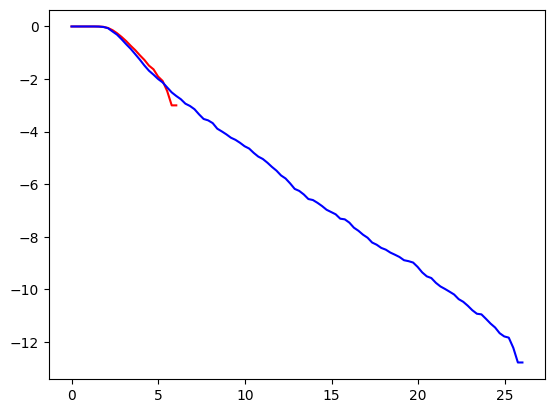

         1070383 function calls (1039921 primitive calls) in 7.628 seconds

   Ordered by: call count

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
    44758    0.005    0.000    0.005    0.000 {method 'get' of 'dict' objects}
    42054    0.008    0.000    0.012    0.000 {built-in method builtins.isinstance}
    38246    0.005    0.000    0.005    0.000 {method 'items' of 'dict' objects}
    31599    0.012    0.000    0.026    0.000 {built-in method builtins.getattr}
    29289    0.004    0.000    0.004    0.000 /home/speersm/.local/lib/python3.10/site-packages/matplotlib/artist.py:816(get_animated)
29277/23050    0.018    0.000    0.027    0.000 /home/speersm/.local/lib/python3.10/site-packages/matplotlib/artist.py:289(stale)
    23163    0.054    0.000    0.054    0.000 {built-in method _codecs.utf_8_decode}
    23163    0.038    0.000    0.092    0.000 /usr/lib/python3.10/codecs.py:319(decode)
    23163    0.005    0.000    0.005    0.000 /usr/lib/python3

In [3]:
# Create a object from cProfile class
profiler = cProfile.Profile()
profiler.enable()
main()
profiler.disable()
# Sort the profiling based on 'ncalls'
stats = pstats.Stats(profiler).sort_stats('ncalls')
# Print the profiling
stats.print_stats()

In [4]:
result = io.StringIO()
stats = pstats.Stats(profiler, stream = result).sort_stats('ncalls')
stats.print_stats()

with open('profiler.txt', 'w+') as f:
    f.write(result.getvalue())

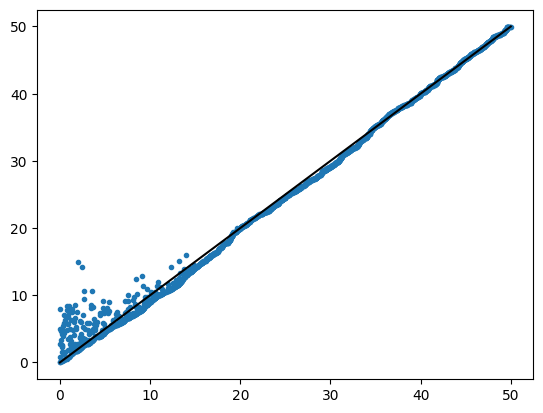

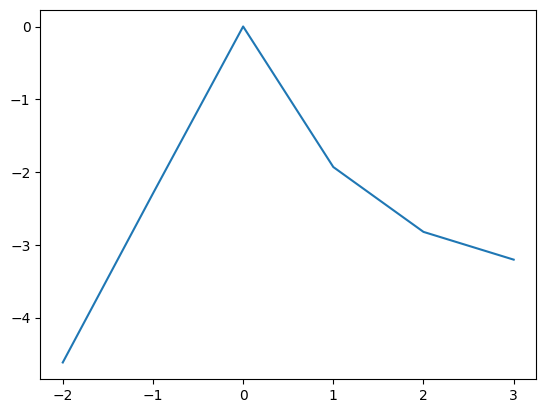

31.447540314481326


/tmp/ipykernel_137567/2400321988.py:184: RuntimeWarning: divide by zero encountered in log10
  plt.plot(x/hs, np.log10(1-sim_is_crest_cdf), '-k')
/tmp/ipykernel_137567/2400321988.py:188: RuntimeWarning: divide by zero encountered in log10
  plt.plot(x/hs, np.log10(1-crest_cdf_two_min_max), '-k')
/tmp/ipykernel_137567/2400321988.py:190: RuntimeWarning: divide by zero encountered in log10
  plt.plot(x/hs, np.log10(1-crest_cdf_is_two_min_max), '--g')
/tmp/ipykernel_137567/2400321988.py:193: RuntimeWarning: divide by zero encountered in log10
  plt.plot(x/hs, np.log10(1-crest_cdf_sea_st_max), '-k')
/tmp/ipykernel_137567/2400321988.py:195: RuntimeWarning: divide by zero encountered in log10
  plt.plot(x/hs, np.log10(1-crest_cdf_is_sea_st_max), '--g')
/tmp/ipykernel_137567/2400321988.py:212: RuntimeWarning: divide by zero encountered in log10
  plt.plot(x_f, np.log10(1-force_cdf_emp), '-r')


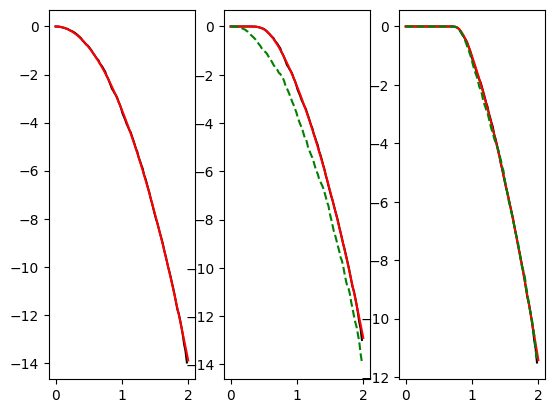

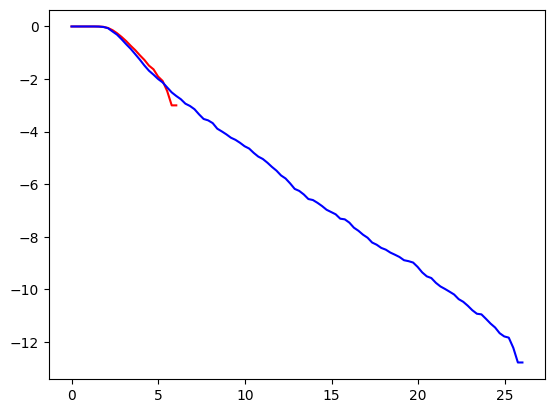

 
*** Profile stats marshalled to file '/tmp/tmpvkwl043g'.
Embedding SnakeViz in this document...


In [5]:
%load_ext snakeviz
%snakeviz main()